# Sample of pixel CNN
### Dataset: MNIST (gray scale image)
### Image generation: Random (not conditional)

### Import Libraries

In [1]:
# --------------------------------------------------
# Libraries
# --------------------------------------------------
import pandas as pd
import numpy as np
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10, STL10
from torchsummary import summary

### GPU

In [2]:
# --------------------------------------------------
# Device
# --------------------------------------------------
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

!nvidia-smi

cuda
Thu Aug 15 13:03:44 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------------------

### Download MNIST dataset

In [3]:

# --------------------------------------------------
# Dataset
# --------------------------------------------------

# Parameter
batch_size = 128

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Datset
train_dataset = torchvision.datasets.MNIST(root = './train', train = True, transform = transform, download = True)
test_dataset = torchvision.datasets.MNIST(root = './test', train = False, transform = transform, download = True)

# DataLoader
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16438889.79it/s]


Extracting ./train/MNIST/raw/train-images-idx3-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 499016.24it/s]


Extracting ./train/MNIST/raw/train-labels-idx1-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1424642.50it/s]


Extracting ./train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4469856.59it/s]


Extracting ./train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./train/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16233727.01it/s]


Extracting ./test/MNIST/raw/train-images-idx3-ubyte.gz to ./test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 511410.22it/s]


Extracting ./test/MNIST/raw/train-labels-idx1-ubyte.gz to ./test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4509959.04it/s]


Extracting ./test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./test/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3747153.57it/s]

Extracting ./test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./test/MNIST/raw



### Training

In [4]:
# --------------------------------------------------
# Model
# --------------------------------------------------

class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        """
        mask_type
            A: Filters that masks its own pixels
            B: Filters that does not mask its own pixels
        """
        super().__init__(*args, **kwargs)
        self.register_buffer("mask", self.weight.data.clone())
        self.mask.fill_(1)
        height = self.weight.size()[2]
        width = self.weight.size()[3]
        if mask_type == "A":
            self.mask[:, :, height//2, width//2:] = 0
            self.mask[:, :, height//2+1:] = 0
        elif mask_type == "B":
            self.mask[:, :, height//2, width//2+1:] = 0
            self.mask[:, :, height//2+1:] = 0
        else:
            raise ValueError("Parameter 'mask_type' must be 'A' or 'B'.")

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

class PixelCNN(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels, n_layers):
        super().__init__()
        # Input layer
        self.input_layer = nn.Sequential(
            MaskedConv2d(mask_type = "A", in_channels = in_channels, out_channels = hidden_channels, kernel_size = 7, stride = 1, padding = 3, bias = False),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU()
        )
        # Stacked layer
        self.stacked_layers = nn.ModuleList()
        for i in range(n_layers):
            self.stacked_layers.append(MaskedConv2d(mask_type = "B", in_channels = hidden_channels, out_channels = hidden_channels, kernel_size = 7, stride = 1, padding = 3, bias = False))
            self.stacked_layers.append(nn.BatchNorm2d(hidden_channels))
            self.stacked_layers.append(nn.ReLU())
        # Output layer
        self.output_layer = nn.Conv2d(hidden_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        out = self.input_layer(x)
        for layer in self.stacked_layers:
            out = layer(out)
        out = self.output_layer(out)
        return out

In [5]:
# --------------------------------------------------
# Model instantiation
# --------------------------------------------------

# Parameters
in_channels = 1
out_channels = 256
hidden_channels = 64
n_layers = 7

# Model
model = PixelCNN(in_channels, out_channels, hidden_channels, n_layers)
model = model.to(device)

# Model summary
summary(model, train_dataset[0][0].size())

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      MaskedConv2d-1           [-1, 64, 28, 28]           3,136
       BatchNorm2d-2           [-1, 64, 28, 28]             128
              ReLU-3           [-1, 64, 28, 28]               0
      MaskedConv2d-4           [-1, 64, 28, 28]         200,704
       BatchNorm2d-5           [-1, 64, 28, 28]             128
              ReLU-6           [-1, 64, 28, 28]               0
      MaskedConv2d-7           [-1, 64, 28, 28]         200,704
       BatchNorm2d-8           [-1, 64, 28, 28]             128
              ReLU-9           [-1, 64, 28, 28]               0
     MaskedConv2d-10           [-1, 64, 28, 28]         200,704
      BatchNorm2d-11           [-1, 64, 28, 28]             128
             ReLU-12           [-1, 64, 28, 28]               0
     MaskedConv2d-13           [-1, 64, 28, 28]         200,704
      BatchNorm2d-14           [-1, 64,

In [6]:
# --------------------------------------------------
# Other training components
# --------------------------------------------------

# Optimizer
lr = 0.001
weight_decay = 0
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

# Loss function
criterion = nn.CrossEntropyLoss()

In [7]:
# --------------------------------------------------
# Training
# --------------------------------------------------

# Settings
epochs = 50
train_loss_minibatch = []
train_loss_epoch = []
test_loss_epoch = []

# Training
for epoch in range(epochs):

    with tqdm(train_loader) as pbar:
        pbar.set_description(f'[Epoch {epoch+1}/{epochs}]')

        # Training step
        model.train()
        for x, _ in pbar:
            # Device
            x = x.to(device)
            # 0-1 scale image -> 0-255 scale image
            target = (x[:,0]*255).long()
            # Parameter update
            output = model(x)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_minibatch.append(loss.item())

        # Evaluation step
        model.eval()
        with torch.no_grad():
            # Train loss
            losses = []
            for x, _ in train_loader:
                x = x.to(device)
                target = (x[:,0]*255).long()
                output = model(x)
                loss = criterion(output, target)
                losses.append(loss.item())
            train_loss_epoch.append(np.mean(losses))

            # Test loss
            losses = []
            for x, _ in test_loader:
                x = x.to(device)
                target = (x[:,0]*255).long()
                output = model(x)
                loss = criterion(output, target)
                losses.append(loss.item())
            test_loss_epoch.append(np.mean(losses))

[Epoch 50/50]: 100%|██████████| 469/469 [01:39<00:00,  4.71it/s]


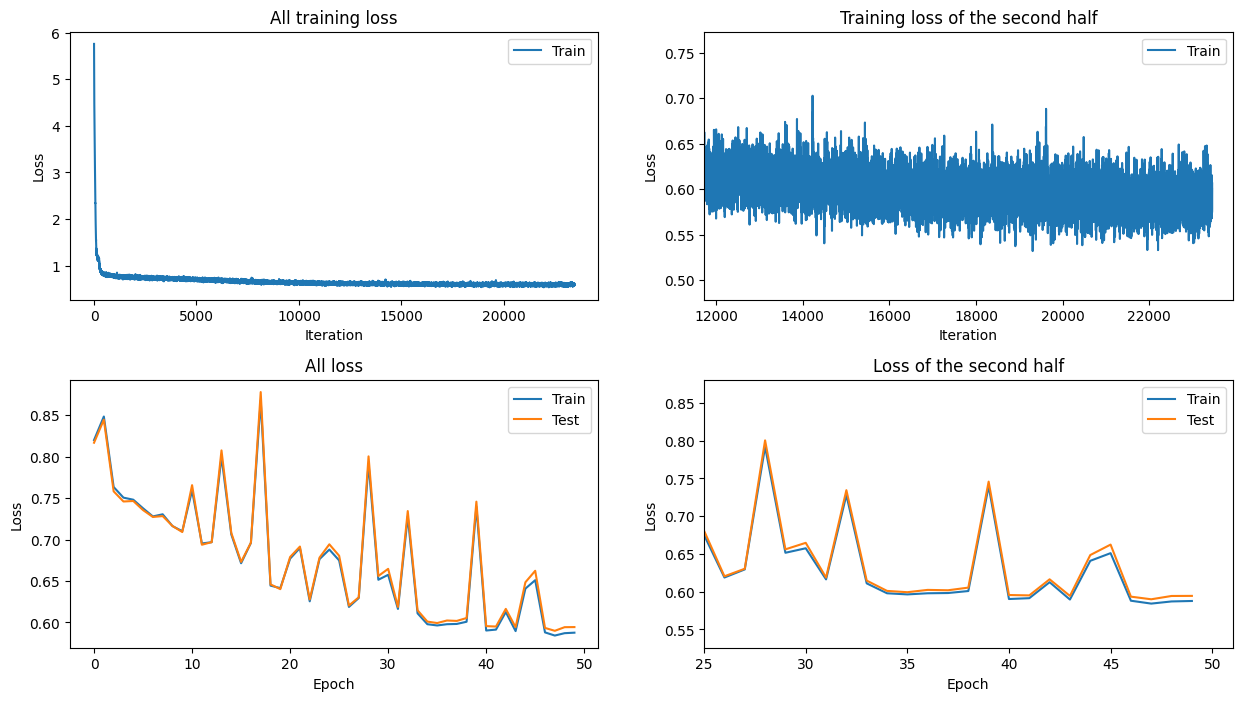

In [153]:
# --------------------------------------------------
# Loss plot
# --------------------------------------------------

fig, ax = plt.subplots(2, 2, figsize = (15, 8))
ax = ax.ravel()
plt.subplots_adjust(hspace = 0.3)

# Loss of training iterations
ax[0].plot(train_loss_minibatch, label = 'Train')
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[0].set_title("All training loss")
ax[1].plot(train_loss_minibatch, label = 'Train')
ax[1].set_xlim(len(train_loss_minibatch)//2, len(train_loss_minibatch)*1.02)
ax[1].set_ylim(min(train_loss_minibatch[len(train_loss_minibatch)//2:])*0.9, max(train_loss_minibatch[len(train_loss_minibatch)//2:])*1.1)
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Loss")
ax[1].legend()
ax[1].set_title("Training loss of the second half")

# Loss of train and test per epoch
ax[2].plot(train_loss_epoch, label = 'Train')
ax[2].plot(test_loss_epoch, label = 'Test')
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Loss")
ax[2].legend()
ax[2].set_title("All loss")
ax[3].plot(train_loss_epoch, label = 'Train')
ax[3].plot(test_loss_epoch, label = 'Test')
ax[3].set_xlim(len(train_loss_epoch)//2, len(train_loss_epoch)*1.02)
ax[3].set_ylim(min(min(train_loss_epoch[len(train_loss_epoch)//2:]), min(test_loss_epoch[len(test_loss_epoch)//2:]))*0.9,
               max(max(train_loss_epoch[len(train_loss_epoch)//2:]), max(test_loss_epoch[len(test_loss_epoch)//2:]))*1.1)
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("Loss")
ax[3].legend()
ax[3].set_title("Loss of the second half")
plt.show()

### Image generation

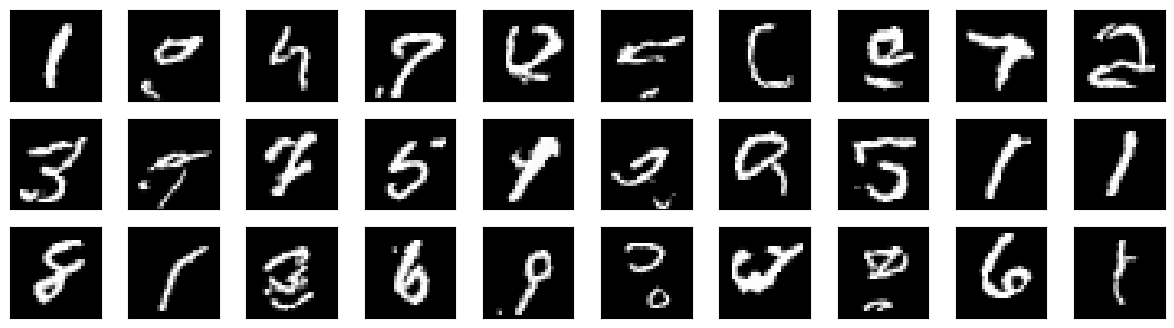

In [9]:
# --------------------------------------------------
# Random image generation
# --------------------------------------------------

def image_generation(model: PixelCNN,
                     device: torch.device,
                     n_images = 30, n_channesl = 1, iamge_hieght = 28, image_width = 28):
    # Initialize
    generated_image = torch.Tensor([0 for i in range(n_images*n_channesl*iamge_hieght*image_width)])
    generated_image = generated_image.view(n_images, n_channesl, iamge_hieght, image_width)
    generated_image = generated_image.to(device)

    # Generation
    model.eval()
    with torch.no_grad():
        for h in range(iamge_hieght):
            for w in range(image_width):
                output = model(generated_image)
                probability = F.softmax(output[:, :, h, w], dim = 1)
                generated_image[:, :, h, w] = torch.multinomial(probability, 1)/255

    # Plot
    fig, ax = plt.subplots(3, 10, figsize = (15, 4))
    ax = ax.ravel()
    for i in range(n_images):
        ax[i].imshow(generated_image[i].permute(1, 2, 0).cpu(), cmap = 'gray')
        ax[i].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
    plt.show()

    return generated_image

# Show image
_ = image_generation(model, device)

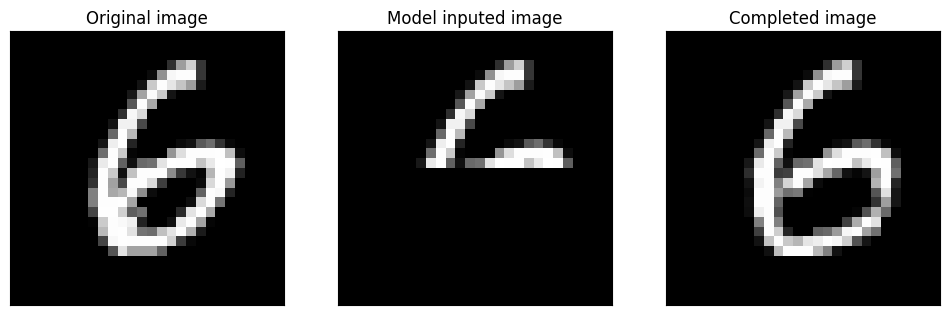

In [133]:
# --------------------------------------------------
# Image completion
# Input: Top half of image
# Output: Bottom half of image
# --------------------------------------------------

def image_completion(model, device, dataset):
    # Random choice
    num_image = len(dataset)
    rng = np.random.default_rng()
    image_number = rng.integers(0, num_image-1)

    # Create model input
    original_image = dataset[image_number][0]
    top_half_image = original_image[:, :14, :]
    bottom_half_image = torch.Tensor([0 for i in range(1*14*28)]).view(1, 14, 28)
    zero_filled_image = torch.cat([top_half_image, bottom_half_image], dim = 1)
    zero_filled_image = zero_filled_image.view(1, 1, 28, 28)

    # Completion
    generated_image = zero_filled_image.to(device)
    model.eval()
    with torch.no_grad():
        for h in range(14, 28):
            for w in range(28):
                output = model(generated_image)
                probability = F.softmax(output[:, :, h, w], dim = 1)
                generated_image[:, :, h, w] = torch.multinomial(probability, 1)/255

    # Plot
    fig, ax = plt.subplots(1, 3, figsize = (12, 4))
    ax[0].imshow(original_image.permute(1, 2, 0).cpu(), cmap = 'gray')
    ax[1].imshow(zero_filled_image[0].permute(1, 2, 0).cpu(), cmap = 'gray')
    ax[2].imshow(generated_image[0].permute(1, 2, 0).cpu(), cmap = 'gray')
    ax[0].set_title("Original image")
    ax[1].set_title("Model inputed image")
    ax[2].set_title("Completed image")
    ax[0].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
    ax[1].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
    ax[2].tick_params(labelbottom = False, labelleft = False, bottom = False, left = False)
    plt.show()

# Show image
image_completion(model, device, test_dataset)